In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 92.5 MB/s 


In [ ]:
import os

import numpy as np

import torch as tc
import torchvision as tv
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.transform import resize

from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [ ]:
batchsize=10
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if tc.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

In [ ]:
trainset = CovidCTDataset(root_dir='/content/drive/MyDrive/TOMProjekt/Dataset',
                              txt_COVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
valset = CovidCTDataset(root_dir='/content/drive/MyDrive/TOMProjekt/Dataset',
                          txt_COVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/COVID/valCT_COVID.txt',
                          txt_NonCOVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='/content/drive/MyDrive/TOMProjekt/Dataset',
                          txt_COVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/COVID/testCT_COVID.txt',
                          txt_NonCOVID='/content/drive/MyDrive/TOMProjekt/Dataset/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)
print("Size of training dataset: " + str(trainset.__len__()))
print("Size of validation dataset: " + str(valset.__len__()))
print("Size of testing dataset: " + str(testset.__len__()))

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

Size of training dataset: 425
Size of validation dataset: 118
Size of testing dataset: 203


In [ ]:
image, label = next(iter(train_loader))

In [ ]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
plt.imshow(data[0,1,:,:].numpy())

In [ ]:
class SimpleNetwork(tc.nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.layer_1 = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU()
        ) 
        self.layer_2 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 32, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU()
        )
        self.layer_3 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 64, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        )
        self.layer_4 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 64, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        )
        self.layer_5 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        self.layer_6 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        self.layer_7 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        self.avg_pool = tc.nn.Sequential(tc.nn.AvgPool2d(1,1))
        self.last_layer = tc.nn.Sequential(
            tc.nn.Linear(128*28*28, 4)
        )

    def forward(self, x):
        print(x.shape)
        x = self.layer_1(x) # Przyklad uzycia pierwszej warstwy
        print(x.shape)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        print(x.shape)
        x = self.avg_pool(x)
        print(x.shape)
        x = x.view(-1, 128*28*28)
        print(x.shape)
        x = self.last_layer(x)
        print(x.shape)
        return x

In [ ]:
model = SimpleNetwork()
for batch_index, batch_samples in enumerate(train_loader):      
    data, target = batch_samples['img'], batch_samples['label']
    output = model(data) # <- Kluczowa linijka kodu, wywołanie funkcji **forward** z klasy SimpleNetwork
    print(f"Output: {tc.nn.Sigmoid()(output)}") # <- w praktyce Sigmoid w celu wyznaczania prawdopodobieństwa umieszcza się poza siecią neuronową

torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
Output: tensor([[0.6915, 0.4302, 0.4332, 0.6529],
        [0.5772, 0.5690, 0.4485, 0.6057],
        [0.5839, 0.5085, 0.5521, 0.5990],
        [0.5718, 0.5900, 0.4397, 0.5166],
        [0.4778, 0.6257, 0.3550, 0.5637],
        [0.5409, 0.4931, 0.5189, 0.5516],
        [0.5248, 0.5989, 0.5659, 0.5562],
        [0.5525, 0.4326, 0.4968, 0.6068],
        [0.6196, 0.6596, 0.3759, 0.3909],
        [0.5985, 0.5835, 0.5786, 0.5610]], grad_fn=<SigmoidBackward0>)
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
Output: tensor([[0.6216, 0.5941, 0.5517, 0.5266],
        [0.6146, 0.5031, 0.4513, 0.4174],
        [0.5671, 0.5940, 0.4522, 0.4569],
        [0.7389, 0.4286, 0.4499, 0.4971],
        [0.4966, 0.5574, 0.4584, 0.

In [ ]:
learning_rate = 0.003 # Współczynnik uczenia, definiuje szybkość treningu, zbyt duży prowadzi do niestabilności, zbyt niski do wolnego uczenia
batch_size = 10 # Liczba obrazów analizowanych w zadanym momencie - większa wartość prowadzi do lepszego wykorzystania GPU, jednak może powodować większy potencjał do wpadania w minima lokalne
num_epochs = 100 # Liczba iteracji przez cały zbiór treningowy
objective_function = tc.nn.CrossEntropyLoss() # Funkcja kosztu, która będzie minimalizowana
model = SimpleNetwork()
parameters = model.parameters() # Parametry, które będą optymalizowane w trakcie treningu sieci
optimizer = tc.optim.Adam(parameters, lr=learning_rate) # Utworzenie obiektu optymalizatora -> w tym przypadku Adam (najpopularniejszy), w uproszczeniu - bardziej zaawansowany wariant spadku gradientowego
device = "cuda:0" # Urządzenie, na którym będzie prowadzony trening, użyjmy karty graficznej, ew. zmienić na "cpu" w przypadku jej braku. Karty graficzne są dostępnę na Google Colaboratory


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tc.cuda.get_device_properties(device)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10

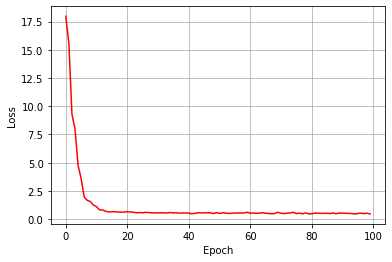

In [ ]:
losses = []
model = model.to(device) # Transfer sieci do pamięci urządzenia (np. GPU)
model.train()
print(f"Dataset size: {len(train_loader.dataset)}")
for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    epoch_loss = 0.0
    for batch_index, batch_samples in enumerate(train_loader):
        data, target = batch_samples['img'], batch_samples['label']
        data, target = data.to(device), target.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        output = model(data) # Przejście obrazów przez model
        loss = objective_function(output, target) # TODO - wyznacz aktualna funkcje kosztu
        loss.backward() # TODO - dokonaj backpropagacji gradientu wykorzystując wyznaczona wartosc kosztu
        optimizer.step() # TODO - dokonaj aktualizacji optymalizatora
        optimizer.zero_grad() # TODO - wyzeruj historie gradientu w optymalizatorze
        epoch_loss += loss.item() * data.size(0)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f"Current epoch loss: {epoch_loss}")

# Wizualizacja pętli treningowej
plt.figure()
plt.plot(losses, "r-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
#Current epoch loss: 0.5512906111338559 dla 60 epoch batch_size 128

In [ ]:
import sklearn.metrics as metrics
predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(test_loader.dataset)}")
    for batch_index, batch_samples in enumerate(train_loader):
        data, target = batch_samples['img'], batch_samples['label']
        data, target = data.to(device), target.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        output = model(data)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.extend(prediction.cpu().numpy().tolist()) # TODO - dokonaj akumulacji predykcji
        targets.extend(target.cpu().numpy().tolist()) # TODO - dokonaj akumulacji prawdziwych wartosci

# TODO - wyznacz macierz pomyłek oraz dokonaj jej wizualizacji (jak ponizej)
print("Testing confusion matrix: \n", metrics.confusion_matrix(targets, predictions))
#metrics.plot_confusion_matrix(model, )
print("Testing classification report: \n", metrics.classification_report(targets, predictions))

Dataset size: 203
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.Size([10, 4])
torch.Size([10, 3, 224, 224])
torch.Size([10, 32, 224, 224])
torch.Size([10, 128, 28, 28])
torch.Size([10, 128, 28, 28])
torch.Size([10, 100352])
torch.

In [ ]:
print("AUC: \n", metrics.roc_auc_score(targets, predictions))

AUC: 
 0.7202420906609388


In [ ]:
print("ACC: \n", metrics.accuracy_score(targets, predictions))

ACC: 
 0.6988235294117647


In [ ]:
print("F1: \n", metrics.f1_score(targets, predictions))

F1: 
 0.6502732240437158


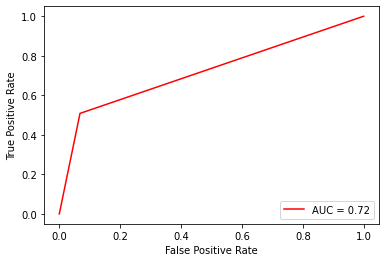

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(color = 'red')
plt.show()

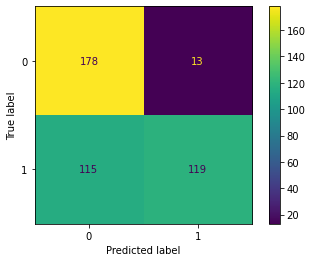

In [ ]:
cm = metrics.confusion_matrix(targets, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()